# Tutorial 5b: Graph Neural Network NPE for Stellar Stream Analysis
Credit: Tri Nguyen and Claude Code

## Overview

In this tutorial, we implement a Neural Posterior Estimation (NPE) model using **Graph Attention Networks (GAT)** to infer dark matter subhalo parameters from stellar stream data. Unlike the MLP-based approach in Tutorial 5, this model treats stream particles as nodes in a graph and leverages graph neural networks to capture spatial relationships.

**Physical Context**: Stellar streams are spatially structured - nearby particles should influence each other more than distant ones. Graph neural networks can naturally encode these relationships by:
- Treating each particle as a graph node  
- Creating edges between nearby particles (k-nearest neighbors)
- Using attention mechanisms to weight particle contributions

**What we'll cover:**
- Using Graph Attention Networks (GAT) for embedding stream data
- Training a Graph NPE model (GAT embedding + Neural Spline Flow)
- Validating with the same coverage tests (rank-based and TARP)
- Comparing performance to the MLP-based model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Loading the Simulation Data

We will first load the stream data from the `data` directory. The data contains 10,000 simulated stellar streams, each with a different subhalo impact scenario. The streams are generated using the `StreamSculptor` package [Nibauer et al. (2024)](https://arxiv.org/abs/2410.21174v1).

**Data Structure:**
- `params_dict`: A dictionary containing the simulation parameters for each stream:
  - `M_sh`: Subhalo mass in solar masses ($\mathrm{M_\odot}$). Shape: `(10000,)`
  - `vz_impact`: Impact velocity in the $z$ direction (line-of-sight) in km/s. Shape: `(10000,)`
- `streams`: The 6D phase-space coordinates of stream stars: $(x, y, z, v_x, v_y, v_z)$
  - Shape: `(10000, N_stars, 6)` where `N_stars = 9998` for all streams in this dataset
  
**Physical Interpretation**: Each stream represents a tidal disruption event that has been perturbed by a passing subhalo. The subhalo mass determines the strength of the perturbation, while the impact velocity affects the timescale and spatial pattern of the disturbance.

In [3]:
with open('data/data.pkl', 'rb') as f:
    data = pickle.load(f)
params_dict = data['params_dict']
streams = data['streams']  # shape: (N_samples, N_particles, 6) # 6 corresponds to (x, y, z, vx, vy, vz)

# params_dict contain two columns: M_sh (the subhalo mass) and vz_impact (the impact velocity along the line of sight)
M_sh = params_dict['M_sh']
vz_impact = params_dict['vz_impact']

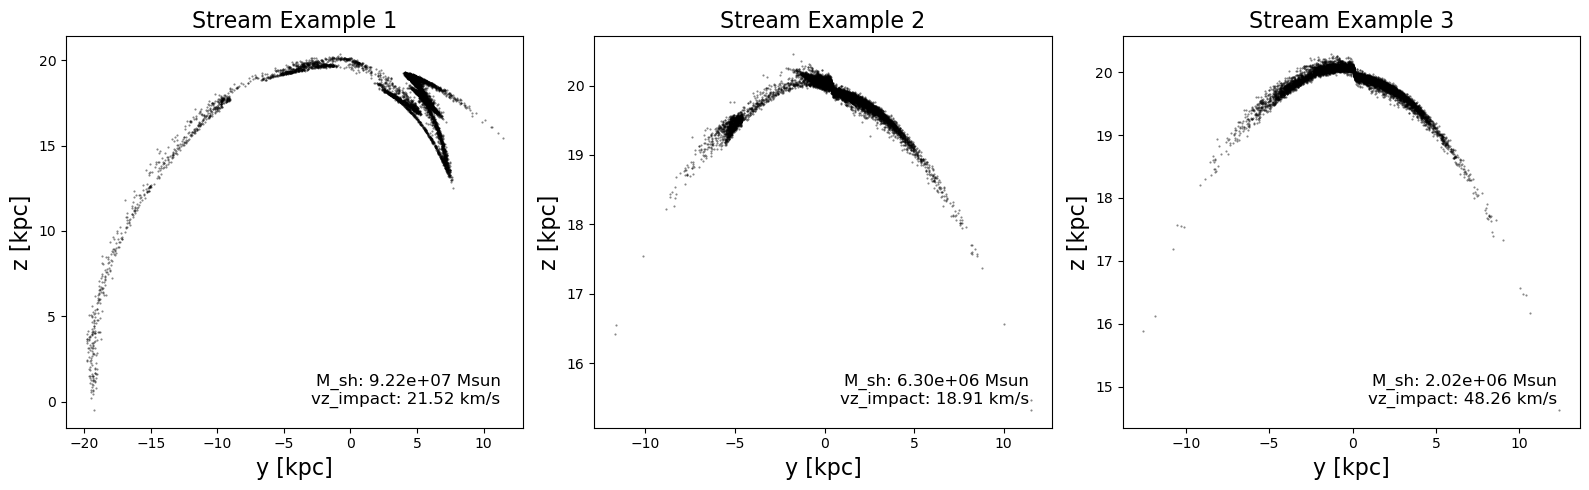

In [4]:
# Figure 1: Plot a few example streams to visualize the data distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, ax in enumerate(axes):
    ax.plot(streams[i, :, 1], streams[i, :, 2], 'k.', markersize=1, alpha=0.5)
    ax.set_title(f'Stream Example {i+1}', fontsize=16)
    ax.set_xlabel('y [kpc]', fontsize=16)
    ax.set_ylabel('z [kpc]', fontsize=16)

    # print some info about the stream
    text = f'M_sh: {M_sh[i]:.2e} Msun\nvz_impact: {vz_impact[i]:.2f} km/s'
    ax.text(0.95, 0.05, text, transform=ax.transAxes, fontsize=12,
            va='bottom', ha='right')

plt.tight_layout()
plt.show()

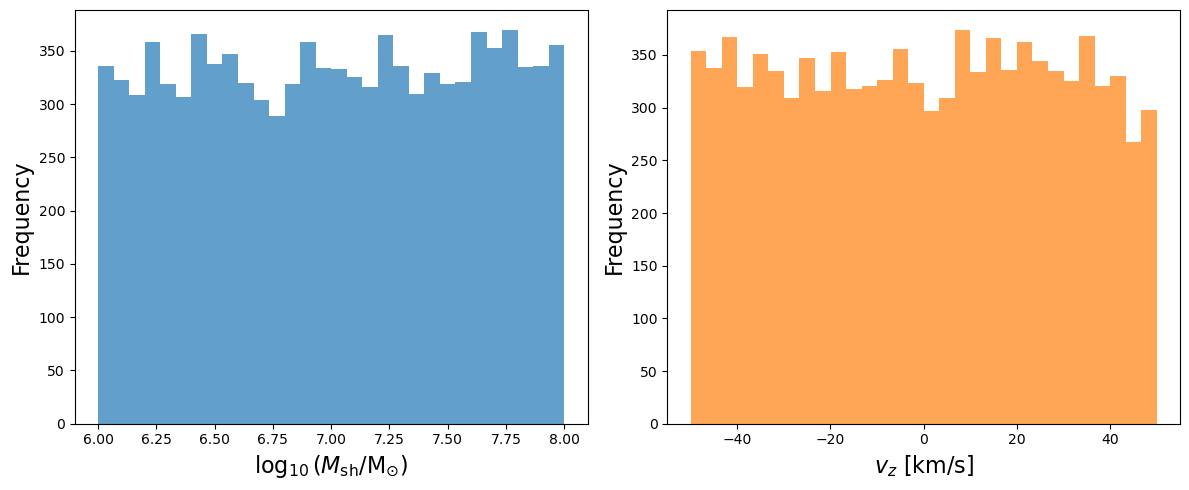

In [5]:
# Figure 2: Plot the distribution of the two parameters to visualize the prior distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(np.log10(M_sh), bins=30, color='C0', alpha=0.7)
axes[0].set_xlabel(r'$\log_{10}(M_\mathrm{sh}/\mathrm{M}_{\odot})$', fontsize=16)
axes[0].set_ylabel('Frequency', fontsize=16)

axes[1].hist(vz_impact, bins=30, color='C1', alpha=0.7)
axes[1].set_xlabel('$v_{z}$ [km/s]', fontsize=16)
axes[1].set_ylabel('Frequency', fontsize=16)

plt.tight_layout()
plt.show()

## Prior Distributions

From the histograms above, we can see that the parameters are sampled from the following distributions:

- $\log_{10} (M_\mathrm{sh} / \mathrm{M_\odot}) \sim \mathcal{U}(6, 8)$
- $v_{z} \sim \mathcal{U}(-50, 50) \, \mathrm{km/s}$

where $\mathcal{U}(a, b)$ denotes a uniform distribution between $a$ and $b$. 

**IMPORTANT**: In NPE, the distributions of parameters in the training dataset effectively define the **prior distributions** $p(\theta)$. The trained model will learn the posterior $p(\theta|x)$ based on these priors.

## Graph NPE: GAT embedding + NSF

We will implement a Graph NPE model that uses Graph Attention Networks (GAT) for embedding and Neural Spline Flows (NSF) for density estimation.

### 1. Preparing the Data for Graph NPE

For the Graph NPE model, we'll construct graphs **during data preparation** rather than in the training loop for efficiency. This involves:

1. **Graph Construction**: Create k-NN graphs based on particle positions
2. **Feature normalization**: Normalize particle features and parameters  
3. **PyG Data objects**: Store each stream as a PyTorch Geometric Data object

**Key difference from MLP approach**: Instead of flattening particles into vectors, we preserve the graph structure and batch using PyTorch Geometric's DataLoader.

In [6]:
from torch_geometric.nn import knn_graph
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader

In [7]:
def prepare_training_graph(streams, params_dict, train_frac=0.9, batch_size=32, k_neighbors=10):
    """
    Prepare training data for Graph NPE model.
    Constructs graphs once during preprocessing rather than in training loop.

    Returns:
        train_loader: PyG DataLoader for training
        val_loader: PyG DataLoader for validation
        norm_dict: Normalization parameters
    """
    N_samples, N_particles, N_features = streams.shape

    # Prepare parameters (log transform mass)
    params = np.vstack((np.log10(params_dict['M_sh']), params_dict['vz_impact'])).T

    # Split into train/val
    N_train = int(train_frac * N_samples)
    streams_train = streams[:N_train]
    streams_val = streams[N_train:]
    params_train = params[:N_train]
    params_val = params[N_train:]

    print(f'Number of training samples: {N_train}')
    print(f'Number of validation samples: {N_samples - N_train}')

    # Compute normalization statistics on training data
    X_train_flat = streams_train.reshape(N_train * N_particles, N_features)
    X_loc = torch.tensor(X_train_flat.mean(0), dtype=torch.float32)
    X_scale = torch.tensor(X_train_flat.std(0), dtype=torch.float32)

    y_train_tensor = torch.tensor(params_train, dtype=torch.float32)
    y_min, y_max = y_train_tensor.min(0)[0], y_train_tensor.max(0)[0]
    y_loc = (y_min + y_max) / 2
    y_scale = (y_max - y_min) / 2

    # Create graphs for training data
    print("\nConstructing graphs for training data...")
    train_graphs = []
    for i in range(N_train):
        # Get particle data
        particle_features = torch.tensor(streams_train[i], dtype=torch.float32)  # (N_particles, 6)
        pos = particle_features[:, :3]  # (N_particles, 3) - positions for k-NN

        # Normalize features using training statistics
        particle_features_norm = (particle_features - X_loc) / X_scale

        # Create k-NN graph based on normalized positions
        edge_index = knn_graph(pos, k=k_neighbors, loop=True)

        # Normalize parameters
        y_norm = (torch.tensor(params_train[i], dtype=torch.float32) - y_loc) / y_scale
        y_norm = y_norm.view(1, -1)  # (1, 2)

        # Create PyG Data object
        data = Data(
            x=particle_features_norm,
            edge_index=edge_index,
            y=y_norm,
            pos=pos
        )
        train_graphs.append(data)

    # Create graphs for validation data
    print("Constructing graphs for validation data...")
    val_graphs = []
    for i in range(N_samples - N_train):
        particle_features = torch.tensor(streams_val[i], dtype=torch.float32)
        pos = particle_features[:, :3]

        # Normalize using training statistics
        particle_features_norm = (particle_features - X_loc) / X_scale
        edge_index = knn_graph(pos, k=k_neighbors, loop=False)

        y_norm = (torch.tensor(params_val[i], dtype=torch.float32) - y_loc) / y_scale
        y_norm = y_norm.view(1, -1)

        data = Data(
            x=particle_features_norm,
            edge_index=edge_index,
            y=y_norm,
            pos=pos
        )
        val_graphs.append(data)

    # Create DataLoaders
    train_loader = PyGDataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    val_loader = PyGDataLoader(val_graphs, batch_size=batch_size, shuffle=False)

    norm_dict = {'X_loc': X_loc, 'X_scale': X_scale, 'y_loc': y_loc, 'y_scale': y_scale}

    print("✓ Graph construction complete!\n")
    return train_loader, val_loader, norm_dict


def subsample_streams(streams, N_particles_subsampled=100):
    """Subsample the streams to a fixed number of particles"""
    N_samples, N_particles, N_features = streams.shape
    if N_particles_subsampled >= N_particles:
        return streams

    streams_subsampled = np.zeros((N_samples, N_particles_subsampled, N_features))
    for i in range(N_samples):
        indices = np.random.choice(N_particles, N_particles_subsampled, replace=False)
        streams_subsampled[i] = streams[i, indices]

    return streams_subsampled

# Subsample and prepare data
streams_subsampled = subsample_streams(streams, N_particles_subsampled=100)
train_loader, val_loader, norm_dict = prepare_training_graph(
    streams_subsampled, params_dict, train_frac=0.9, batch_size=32, k_neighbors=10
)

Number of training samples: 9000
Number of validation samples: 1000

Constructing graphs for training data...
Constructing graphs for validation data...
✓ Graph construction complete!



DataBatch(x=[3200, 6], edge_index=[2, 32000], y=[32, 2], pos=[3200, 3], batch=[3200], ptr=[33])


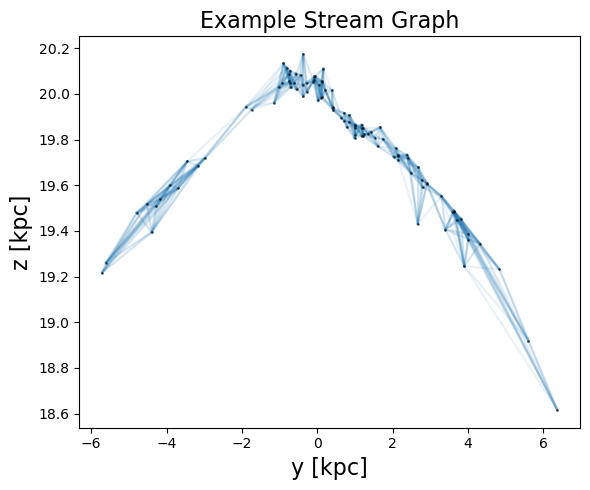

In [8]:
# Take an example batch from the validation loader and plot
example_batch = next(iter(val_loader))
print(example_batch)

# Plot example graph
fig, ax = plt.subplots(figsize=(6, 5))

example_graph = example_batch[1]

# plot nodes
pos = example_graph.pos.numpy()
ax.scatter(pos[:, 1], pos[:, 2], c='k', s=1, alpha=0.5)

# plot edges
for i in range(example_graph.edge_index.shape[1]):
    src = example_graph.edge_index[0, i].item()
    dst = example_graph.edge_index[1, i].item()
    ax.plot(
        [pos[src, 1], pos[dst, 1]], [pos[src, 2], pos[dst, 2]],
        'C0-', alpha=0.1, zorder=-1)

ax.set_title('Example Stream Graph', fontsize=16)
ax.set_xlabel('y [kpc]', fontsize=16)
ax.set_ylabel('z [kpc]', fontsize=16)
plt.tight_layout()

### 2. Create and Train the Graph NPE Model

Now we'll create our Graph NPE model and train it. The model consists of three main components:

1. **Graph Construction**: Builds k-nearest neighbor graphs based on particle positions
2. **GAT Embedding Network**: Uses graph attention layers to process the spatial structure
   - Multiple GAT layers with multi-head attention
   - Global mean pooling to aggregate node features
   - Final MLP to produce fixed-size embedding
3. **Neural Spline Flow**: Same as before - learns conditional posterior $p(\theta|x)$

**Key advantages of GAT:**
- Captures spatial relationships between particles
- Attention mechanism learns which particles are most informative
- Permutation invariant (order of particles doesn't matter)

For more on NPE training, see Tutorial 1.

In [9]:
from models import graph_npe

In [10]:
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, device='cpu'):
    """
    Train the NPE model given training and validation data loaders.
    Works with PyG DataLoader that returns (batch_data, batch_params).
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    device = torch.device(device)
    model.to(device)

    train_losses = []
    val_losses = []
    print(f"Training for {epochs} epochs...\n")

    for epoch in range(epochs):

        model.train()
        epoch_loss = 0.0
        n_batches = 0
        for batch_data in train_loader:
            optimizer.zero_grad()
            theta_batch = batch_data.y.to(device)
            log_prob = model.log_prob(theta_batch, batch_data.to(device))
            loss = -log_prob.mean()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        train_losses.append(avg_loss)

        # compute the validation loss at the end of each epoch
        model.eval()
        val_epoch_loss = 0.0
        n_val_batches = 0
        with torch.no_grad():
            for batch_data in val_loader:
                theta_val_batch = batch_data.y.to(device)
                val_log_prob = model.log_prob(theta_val_batch, batch_data.to(device))
                val_loss = -val_log_prob.mean()

                val_epoch_loss += val_loss.item()
                n_val_batches += 1
        val_avg_loss = val_epoch_loss / n_val_batches
        val_losses.append(val_avg_loss)

        # print progress every epoch
        print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_avg_loss:.4f}")

    print("\n✓ Training complete!")
    return train_losses, val_losses

Note that training GNN models are more computationally intensive than MLPs, so training time will be longer. I highly recommend using a GPU if available.

In [ ]:
graph_npe_model = graph_npe.GraphNPE(
    node_features=6,  # (x, y, z, vx, vy, vz) per particle
    output_dim=2,  # (log10(M_sh), vz_impact)
    hidden_size=32,
    embedding_size=8,
    transforms=6,
    num_gat_layers=3,
    heads=4
)

# note: unlike the MLP + NPE model, the Graph NPE model will require more epochs to converge
# I set 20 epochs here for demonstration purposes, but you may want to increase this to 50 for better results
train_losses, val_losses = train_model(
    graph_npe_model, train_loader, val_loader, epochs=50, lr=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu'   # use GPU if available
)
graph_npe_model.cpu()  # move model back to CPU after training

Training for 50 epochs...

Epoch   1/50 | Train Loss: 1.8373 | Val Loss: 1.5161
Epoch   2/50 | Train Loss: 0.7789 | Val Loss: 0.4370
Epoch   3/50 | Train Loss: 0.2990 | Val Loss: 0.2238
Epoch   4/50 | Train Loss: 0.1108 | Val Loss: 0.0711
Epoch   5/50 | Train Loss: -0.0451 | Val Loss: -0.0914
Epoch   6/50 | Train Loss: -0.2361 | Val Loss: -0.2126
Epoch   7/50 | Train Loss: -0.4038 | Val Loss: -0.4366
Epoch   8/50 | Train Loss: -0.5473 | Val Loss: -0.5839
Epoch   9/50 | Train Loss: -0.6516 | Val Loss: -0.6742
Epoch  10/50 | Train Loss: -0.7228 | Val Loss: -0.7502
Epoch  11/50 | Train Loss: -0.8115 | Val Loss: -0.7632
Epoch  12/50 | Train Loss: -0.8632 | Val Loss: -0.8886


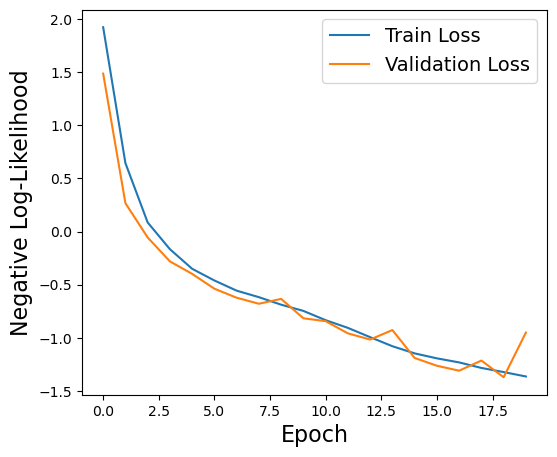

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Negative Log-Likelihood', fontsize=16)
ax.legend(fontsize=14)
plt.show()

We see that the loss value is significantly lower than that of the MLP-based model, indicating better fit to the data. Let's see how well the model performs in inference.

### 3. Visualizing Posterior Samples with Corner Plots

Now that our model is trained, let's test it on some validation examples by sampling from the posterior $p(\theta|x)$ and visualizing the results with corner plots.

In [ ]:
# Install corner for visualization if needed
try:
    import corner
    print("corner library is already installed.")
except ImportError:
    !pip install corner
    import corner
    print("corner library installed successfully.")

corner library is already installed.


In [ ]:
def sample_single_obs(model, x_obs, norm_dict, n_samples=5000, k_neighbors=10):
    """
    Sample from the posterior p(θ|x) for a single observation.
    Creates graph on the fly for this single observation.

    Parameters:
    - model: trained GraphNPE model
    - x_obs: observation (N_particles, N_features) array
    - norm_dict: normalization parameters
    - n_samples: number of samples to draw
    - k_neighbors: k for k-NN graph construction

    Returns:
    - samples: (n_samples, n_params) array in original parameter space
    """
    model.eval()

    # Convert to tensor and get shapes
    x_obs = torch.tensor(x_obs, dtype=torch.float32)
    N_particles, N_features = x_obs.shape

    # Normalize features
    x_obs_norm = (x_obs - norm_dict['X_loc']) / norm_dict['X_scale']
    x_obs_norm = x_obs_norm.reshape(N_particles, N_features)

    # Get normalized positions for k-NN graph
    pos = x_obs[:, :3]

    # Create k-NN graph
    edge_index = knn_graph(pos, k=k_neighbors, loop=False)

    # Create PyG Data object
    data = Data(x=x_obs_norm, edge_index=edge_index, pos=pos)
    batch_data = Batch.from_data_list([data])

    # Sample from model
    with torch.no_grad():
        samples_normalized = model.sample(batch_data, n_samples)
        samples = samples_normalized.cpu().numpy().squeeze()
        samples = samples * norm_dict['y_scale'].numpy() + norm_dict['y_loc'].numpy()

    return samples

In [ ]:
# Select a few test examples from validation set
n_test_examples = 3
test_indices = [9000, 9200, 9500]  # indices from validation set

# Prepare test data (same preprocessing as training data)
test_streams = streams_subsampled[test_indices]
test_params = np.vstack((np.log10(M_sh[test_indices]), vz_impact[test_indices])).T

print(f"Sampling posteriors for {n_test_examples} test examples...")

# Sample from posterior for each test example
posterior_samples = []
for i, idx in enumerate(test_indices):
    samples = sample_single_obs(graph_npe_model, test_streams[i], norm_dict, n_samples=10_000)
    posterior_samples.append(samples)
    print(f"- Example {i+1}: log10(M_sh)={test_params[i, 0]:.2f}, vz={test_params[i, 1]:.1f} km/s")

Sampling posteriors for 3 test examples...
- Example 1: log10(M_sh)=6.06, vz=22.9 km/s
- Example 2: log10(M_sh)=6.96, vz=31.6 km/s
- Example 3: log10(M_sh)=7.33, vz=-33.5 km/s


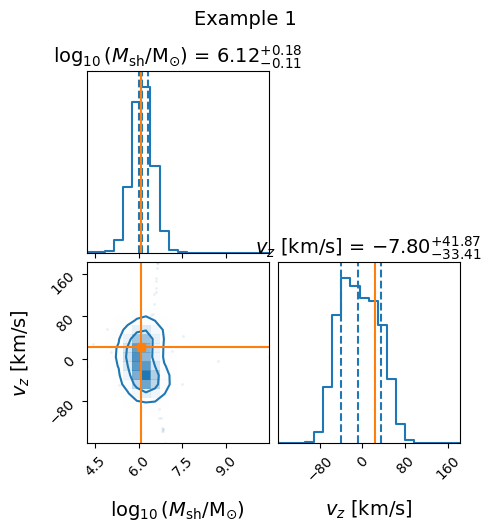

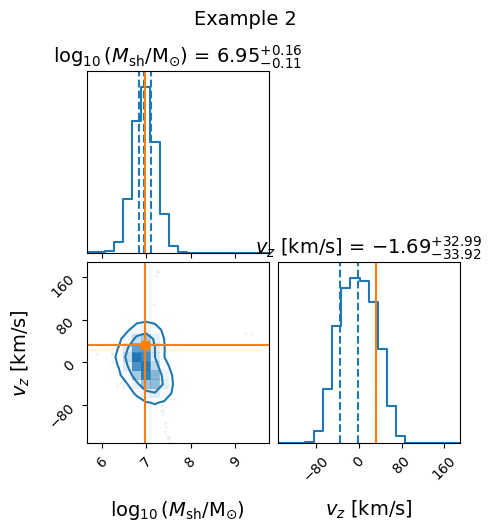

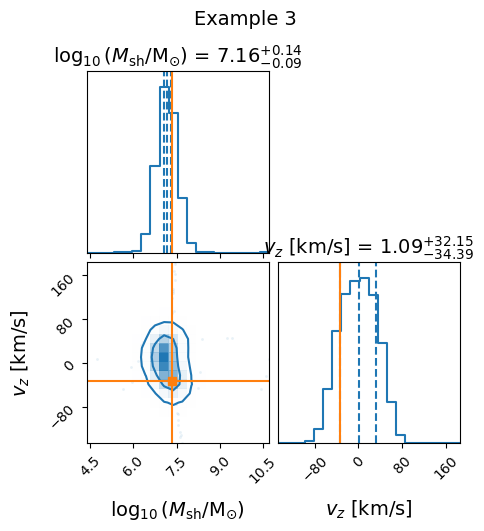

In [ ]:
# Plot the posterior samples using corner
for i in range(n_test_examples):
    fig = plt.figure(figsize=(5, 5))
    fig = corner.corner(
        posterior_samples[i],
        labels=[r'$\log_{10}(M_\mathrm{sh}/\mathrm{M}_{\odot})$', r'$v_{z}$ [km/s]'],
        truths=test_params[i],
        show_titles=True,
        title_fmt='.2f',
        title_kwargs={"fontsize": 14},
        label_kwargs={"fontsize": 14},
        bins=20,
        levels=(0.68, 0.95),
        quantiles=[0.16, 0.5, 0.84],
        smooth=1.0,
        smooth1d=1.0,
        color='C0',
        truth_color='C1',
        fig=fig
    )
    fig.suptitle(f'Example {i+1}', fontsize=14, y=1.05)
    plt.show()

**Note on Flow Leakage:** When using normalizing flows, be cautious of flow leakage - a phenomenon where the flow assigns non-negligible probability mass to parameter regions outside the prior bounds. This can occur when:
- The flow's base distribution (usually Gaussian) has unbounded support while the prior is bounded
- Training data doesn't adequately sample the prior boundaries
- The flow architecture doesn't enforce hard constraints

### 4. Validation Tests

Similarly with Tutorial 5a, we will perform two tests:
1. **Predicted vs True**: Plot the predicted posterior means against the true parameter values for all validation examples. This gives a quick visual check of bias and scatter.
2. **Coverage Tests**: Evaluate how well the predicted posteriors capture the true parameters using rank-based and TARP coverage tests.

In [ ]:
def sample_posteriors(model, loader, norm_dict, n_samples=5000):
    """
    Sample from posteriors for all observations in the DataLoader.
    Works with PyG DataLoader containing pre-constructed graphs.

    Parameters:
    - model: trained GraphNPE model
    - loader: PyG DataLoader with graph batches
    - norm_dict: normalization parameters
    - n_samples: number of samples per posterior

    Returns:
    - posteriors: (n_tests, n_samples, n_params) array
    - truths: (n_tests, n_params) array
    """
    model.eval()
    posteriors_list = []
    truths_list = []

    with torch.no_grad():
        for batch_data in loader:
            # Sample from flow
            samples_normalized = model.sample(batch_data, n_samples)

            # zuko returns (n_samples, batch_size, output_dim)
            # reshape to (batch_size, n_samples, output_dim)
            samples_normalized = samples_normalized.permute(1, 0, 2)

            # Denormalize
            samples = samples_normalized.cpu().numpy()
            samples = samples * norm_dict['y_scale'].numpy() + norm_dict['y_loc'].numpy()
            posteriors_list.append(samples)

            # Get true parameters
            truths = batch_data.y.cpu().numpy()
            truths = truths * norm_dict['y_scale'].numpy() + norm_dict['y_loc'].numpy()
            truths_list.append(truths)

    posteriors = np.concatenate(posteriors_list, axis=0)
    truths = np.concatenate(truths_list, axis=0)

    return posteriors, truths


posterior_samples_all, truths_all = sample_posteriors(
    graph_npe_model, val_loader, norm_dict, n_samples=2000
)

We will first plot the predicted vs true values for both parameters across all validation examples. Ideally, points should lie along the diagonal line, indicating accurate predictions.

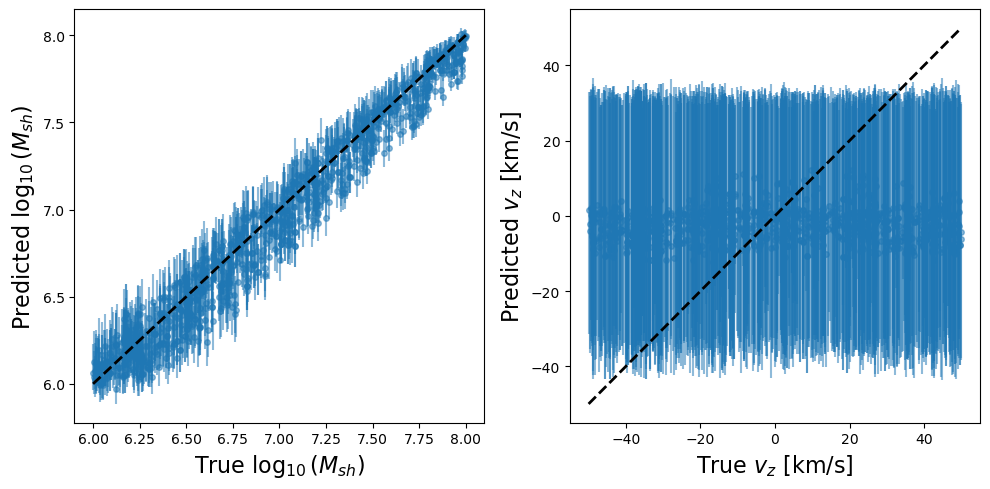

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Compute point estimates (median) and uncertainties (16th and 84th percentiles)
predicted_median, predicted_lower, predicted_upper = np.percentile(
    posterior_samples_all, [50, 16, 84], axis=1)

# True vs Predicted for log10(M_sh)
axes[0].errorbar(
    truths_all[:, 0],
    predicted_median[:, 0],
    yerr=[predicted_median[:, 0] - predicted_lower[:, 0],
          predicted_upper[:, 0] - predicted_median[:, 0]],
    fmt='o', markersize=4, alpha=0.5, label='Predictions',
    zorder=0
)
axes[0].plot([6, 8], [6, 8], 'k--', lw=2, zorder=1)
axes[0].set_xlabel(r'True $\log_{10}(M_{sh})$', fontsize=16)
axes[0].set_ylabel(r'Predicted $\log_{10}(M_{sh})$', fontsize=16)

# True vs Predicted for vz_impact
axes[1].errorbar(
    truths_all[:, 1],
    predicted_median[:, 1],
    yerr=[predicted_median[:, 1] - predicted_lower[:, 1],
          predicted_upper[:, 1] - predicted_median[:, 1]],
    fmt='o', markersize=4, alpha=0.5, label='Predictions',
    zorder=0
)
axes[1].plot([-50, 50], [-50, 50], 'k--', lw=2, zorder=1)
axes[1].set_xlabel(r'True $v_z$ [km/s]', fontsize=16)
axes[1].set_ylabel(r'Predicted $v_z$ [km/s]', fontsize=16)

plt.tight_layout()

Now let's validate our NPE model using the calibration tests from Tutorial 04:
- **Rank-based test**: Checks if marginal posteriors are well-calibrated
- **TARP**: Tests joint posterior calibration

In [ ]:
from scipy.stats import kstest
from scipy import stats

# Install tarp for coverage tests if needed
try:
    import tarp
    print("tarp library is already installed.")
except ImportError:
    !pip install deprecation tarp
    import tarp
    print("tarp library installed successfully.")

tarp library is already installed.


#### Rank-based Test
See Tutorial 04 for details on the rank-based calibration test. We'll apply it separately for each parameter, since this test only works for 1D marginals.

In [ ]:
def rank_based_calibration(theta_true, theta_samples):
    """
    Compute ranks for the rank-based calibration test.

    Parameters:
    - theta_true: (n_tests,) array of true parameter values
    - theta_samples: (n_tests, n_samples) array of posterior samples

    Returns:
    - ranks: (n_tests,) array of ranks (normalized to [0, 1])
    """
    n_tests, n_samples = theta_samples.shape

    # For each test case, count how many samples are less than the true value
    ranks = np.sum(theta_samples < theta_true.reshape(-1, 1), axis=1)

    # Normalize ranks to [0, 1]
    normalized_ranks = ranks / n_samples

    return normalized_ranks

# Compute ranks for each parameter separately
ranks_log_mass = rank_based_calibration(truths_all[:, 0], posterior_samples_all[:, :, 0])
ranks_vz = rank_based_calibration(truths_all[:, 1], posterior_samples_all[:, :, 1])

print("Rank-based Calibration Statistics:")
print(f"\nlog10(M_sh):")
print(f"  Mean: {ranks_log_mass.mean():.3f} (expected: 0.500)")
print(f"  Std:  {ranks_log_mass.std():.3f} (expected: {1/np.sqrt(12):.3f})")
print(f"\nvz:")
print(f"  Mean: {ranks_vz.mean():.3f} (expected: 0.500)")
print(f"  Std:  {ranks_vz.std():.3f} (expected: {1/np.sqrt(12):.3f})")

Rank-based Calibration Statistics:

log10(M_sh):
  Mean: 0.580 (expected: 0.500)
  Std:  0.263 (expected: 0.289)

vz:
  Mean: 0.522 (expected: 0.500)
  Std:  0.292 (expected: 0.289)


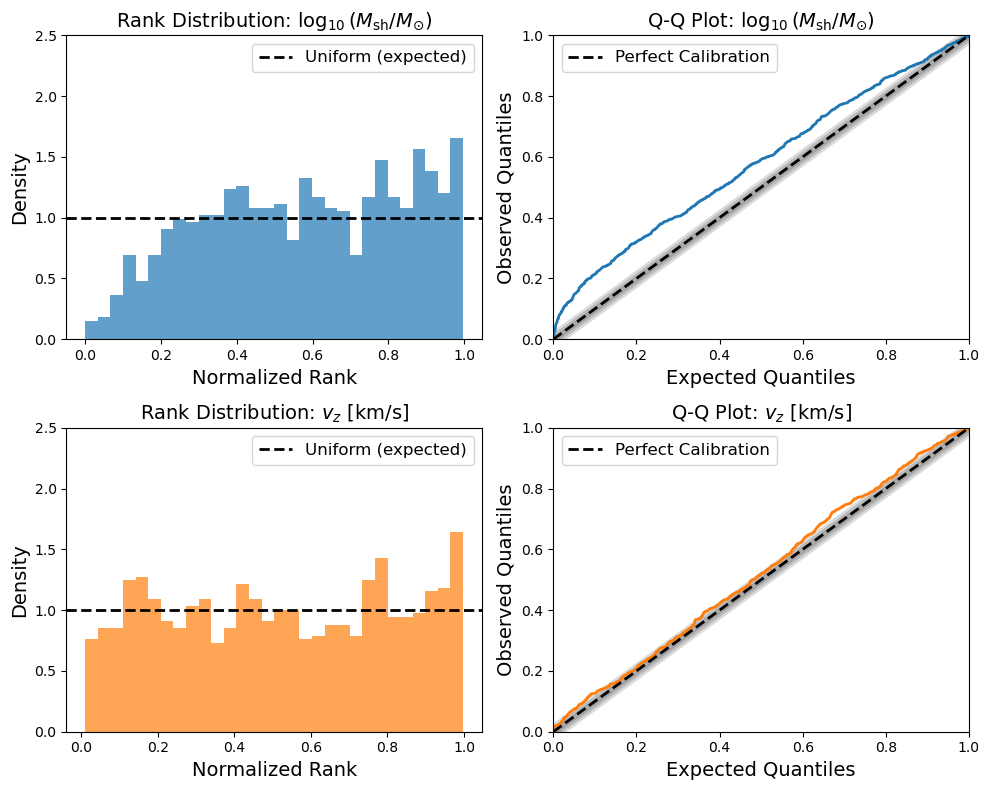

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

param_names = [r'$\log_{10}(M_{\rm sh}/M_{\odot})$', r'$v_z$ [km/s]']
all_ranks = [ranks_log_mass, ranks_vz]

for param_idx, (ranks, param_name) in enumerate(zip(all_ranks, param_names)):
    # Histogram
    ax = axes[param_idx, 0]
    ax.hist(ranks, bins=30, color=f'C{param_idx}', density=True, alpha=0.7)
    ax.axhline(1.0, color='black', linestyle='--', linewidth=2, label='Uniform (expected)')
    ax.set_xlabel('Normalized Rank', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_title(f'Rank Distribution: {param_name}', fontsize=14)
    ax.legend(fontsize=12)
    ax.set_ylim([0, 2.5])

    # Q-Q plot
    ax = axes[param_idx, 1]
    sorted_ranks = np.sort(ranks)
    theoretical_quantiles = np.linspace(0, 1, len(sorted_ranks))
    ax.plot(theoretical_quantiles, sorted_ranks, '-', lw=2, color=f'C{param_idx}')
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)

    # Confidence bands (1, 2, 3 sigma)
    n = len(ranks)
    se = 1 / np.sqrt(12 * n)
    sigmas = [1, 2, 3]
    alphas = [0.4, 0.3, 0.2]
    quantiles = np.linspace(0, 1, 100)
    for sigma, alpha_val in zip(sigmas, alphas):
        lower_band = np.maximum(quantiles - sigma * se, 0)
        upper_band = np.minimum(quantiles + sigma * se, 1)
        ax.fill_between(quantiles, lower_band, upper_band, alpha=alpha_val, color='gray')

    ax.legend(fontsize=12)
    ax.set_xlabel('Expected Quantiles', fontsize=14)
    ax.set_ylabel('Observed Quantiles', fontsize=14)
    ax.set_title(f'Q-Q Plot: {param_name}', fontsize=14)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

In [ ]:
# Perform Kolmogorov-Smirnov test
ks_stat_mass, p_value_mass = kstest(ranks_log_mass, 'uniform')
ks_stat_vz, p_value_vz = kstest(ranks_vz, 'uniform')

print(f"""Kolmogorov-Smirnov Test Results
(Tests if ranks are uniformly distributed)

log10(M_sh):
  KS statistic: {ks_stat_mass:.4f}
  p-value: {p_value_mass:.4f}
  {'✓ Well calibrated' if p_value_mass > 0.05 else '✗ Poor calibration'}

vz:
  KS statistic: {ks_stat_vz:.4f}
  p-value: {p_value_vz:.4f}
  {'✓ Well calibrated' if p_value_vz > 0.05 else '✗ Poor calibration'}

Note: p-value > 0.05 suggests good calibration
""")

Kolmogorov-Smirnov Test Results
(Tests if ranks are uniformly distributed)

log10(M_sh):
  KS statistic: 0.1260
  p-value: 0.0000
  ✗ Poor calibration

vz:
  KS statistic: 0.0520
  p-value: 0.0086
  ✗ Poor calibration

Note: p-value > 0.05 suggests good calibration



#### TARP Calibration Test

See Tutorial 04 for details on TARP ([Lemos et al. 2023](https://arxiv.org/abs/2302.03026)). Unlike the rank-based test, TARP can detect miscalibration in the joint posterior distribution.

In [ ]:
# Apply TARP coverage test
print("Running TARP coverage test...")
print("This may take a minute...\n")

# TARP expects shape: (n_samples, n_tests, n_params)
# We have: (n_tests, n_samples, n_params)
# So we need to transpose the first two dimensions
tarp_samples = np.transpose(posterior_samples_all, (1, 0, 2))

ecp, alpha = tarp.get_tarp_coverage(
    tarp_samples,  # shape: (n_samples, n_tests, n_params)
    truths_all,    # shape: (n_tests, n_params)
    bootstrap=True,
    num_bootstrap=100
)

print("✓ TARP test complete!")

Running TARP coverage test...
This may take a minute...



100%|██████████| 100/100 [00:02<00:00, 37.73it/s]

✓ TARP test complete!


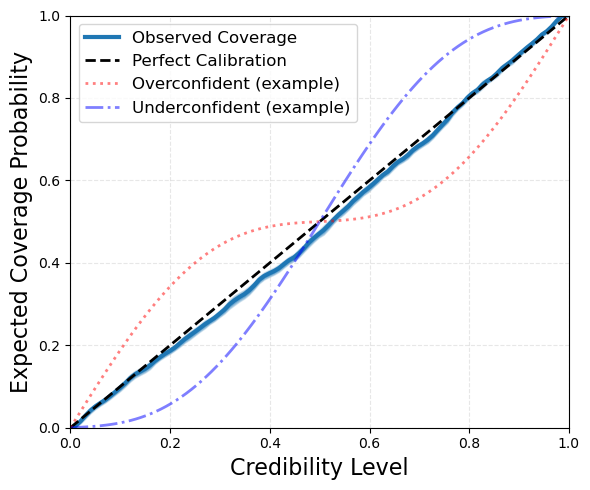

In [ ]:
# Plot TARP Expected Coverage Probability (ECP) curve
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Plot the mean ECP curve
ax.plot(alpha, ecp.mean(axis=0), label='Observed Coverage', color='C0', linewidth=3)
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)

# Plot confidence bands (1, 2, 3 sigma) from bootstrap
sigmas = [1, 2, 3]
alphas_fill = [0.4, 0.3, 0.2]
for k, alpha_val in zip(sigmas, alphas_fill):
    ax.fill_between(
        alpha,
        ecp.mean(axis=0) - k * ecp.std(axis=0),
        ecp.mean(axis=0) + k * ecp.std(axis=0),
        color='C0', alpha=alpha_val,
    )

# Add reference curves for over/under-confident
x_region = np.linspace(0, 1, 100)
overconfident_curve = x_region + 0.15 * np.sin(2 * np.pi * x_region)
underconfident_curve = x_region - 0.15 * np.sin(2 * np.pi * x_region)
ax.plot(x_region, overconfident_curve, color='red', ls='dotted',
        linewidth=2, alpha=0.5, label='Overconfident (example)')
ax.plot(x_region, underconfident_curve, color='blue', ls='dashdot',
        linewidth=2, alpha=0.5, label='Underconfident (example)')

ax.set_xlabel('Credibility Level', fontsize=16)
ax.set_ylabel('Expected Coverage Probability', fontsize=16)
ax.legend(fontsize=12, loc='upper left')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Summary

In this tutorial, we implemented a Graph Neural Network-based NPE model using Graph Attention Networks (GAT) for embedding stellar stream data. This approach leverages the spatial structure of the streams by treating particles as nodes in a graph and using attention mechanisms to capture local correlations.

We find that the model can recover subhalo parameters with better accuracy than the MLP approach. However, calibration tests indicate some miscalibration in the joint posterior. This highlights that posterior calibration can be much more challenging than point estimation and persists even with more sophisticated architectures. Further improvements could include:
- Tuning GAT architecture and hyperparameters
- Increasing the number of training samples
